In [88]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick as yb
import shap
import lime

In [89]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
folder_path = "E:\\Formation Data Scientist\\Projet_5\\ressources\\archive\\"
customers = pd.read_csv(folder_path + "olist_customers_dataset.csv")
order_items = pd.read_csv(folder_path + "olist_order_items_dataset.csv")
orders = pd.read_csv(folder_path + "olist_orders_dataset.csv")
geolocation = pd.read_csv(folder_path + 'olist_geolocation_dataset.csv')
order_payments = pd.read_csv(folder_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(folder_path + 'olist_order_reviews_dataset.csv')
products = pd.read_csv(folder_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(folder_path + 'olist_sellers_dataset.csv')
translation = pd.read_csv(folder_path + 'product_category_name_translation.csv')


In [91]:
print(customers.shape)
print(order_items.shape)
print(orders.shape)
print(geolocation.shape)
print(order_payments.shape)
print(order_reviews.shape)
print(products.shape)
print(sellers.shape)
print(translation.shape)

(99441, 5)
(112650, 7)
(99441, 8)
(1000163, 5)
(103886, 5)
(99224, 7)
(32951, 9)
(3095, 4)
(71, 2)


In [92]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [93]:
customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [94]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [95]:
geolocation.head(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


- Merge des catégories de produits et leur nom en Anglais

In [96]:
fus_cats = pd.merge(products,translation,indicator=True)

In [97]:
fus_cats.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,_merge
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,both


- Drop des colonnes non essentielles

In [98]:
fus_cats.drop(columns=['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm',
              'product_width_cm','_merge'],inplace=True)

In [99]:
fus_cats.shape

(32328, 3)

In [100]:
fus_cats.isna().sum()

product_id                       0
product_category_name            0
product_category_name_english    0
dtype: int64

- Fusion de la trame des **clients** et de la trame des **commandes**

In [101]:
fus1 = pd.merge(customers,orders, indicator=True)

In [102]:
fus1.shape

(99441, 13)

In [103]:
fus1.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,_merge
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,both


In [104]:
fus1 = fus1.drop(columns='_merge')

In [105]:
fus1_ = pd.merge(fus1,order_reviews, indicator=True)

In [106]:
fus1_['_merge'].value_counts()

both          99224
left_only         0
right_only        0
Name: _merge, dtype: int64

In [107]:
fus1_ = fus1_.drop(columns='_merge')

- Fusion de la trame des **clients** et **commandes** avec la trame **paiements**

In [108]:
fus2 = pd.merge(fus1_,order_payments, indicator=True)

In [109]:
fus2

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,_merge
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,both
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,both
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,both
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,both
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103672,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,...,4,Recomendo,NaN,2018-04-14 00:00:00,2018-04-28 11:15:04,1,credit_card,6,88.78,both
103673,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,...,5,NaN,NaN,2018-04-12 00:00:00,2018-04-16 10:36:05,1,credit_card,3,129.06,both
103674,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,...,1,Chateada,Esperava qualidade no atendimento e estou tend...,2018-05-04 00:00:00,2018-05-08 01:41:07,1,credit_card,5,56.04,both
103675,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,...,5,NaN,NaN,2017-11-17 00:00:00,2017-11-19 23:34:18,1,credit_card,2,711.07,both


In [110]:
fus2 = fus2.drop(columns='_merge')

- Fusion de la trame des **produits** avec celle des **catégories** de produits

In [111]:
fus3 = pd.merge(order_items,fus_cats)

In [112]:
fus4 = pd.merge(fus3,fus2)

In [113]:
fus4.isna().sum()

order_id                              0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_category_name_english         0
customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             101808
review_comment_message            66703
review_creation_date                  0


In [114]:
#fus4.dropna(axis=0,inplace=True)

In [115]:
fus4.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1,credit_card,2,72.19


In [116]:
fus4.shape

(115609, 30)

In [117]:
fus4.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [118]:
fus5 = pd.merge(fus4,sellers)

In [119]:
fus5.shape

(115609, 33)

In [120]:
fus5.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'seller_zip_code_prefix',
       'seller_city', 'seller_state'],
      dtype='object')

In [121]:
#fus5 = pd.merge(fus4,geolocation,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',indicator=True)

In [122]:
fus5.shape

(115609, 33)

<AxesSubplot:>

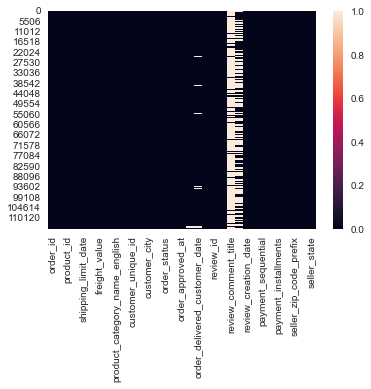

In [123]:
sns.heatmap(fus5.isna())

In [124]:
fus5.isna().sum()

order_id                              0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_category_name_english         0
customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             101808
review_comment_message            66703
review_creation_date                  0


In [125]:
fus5.duplicated().sum()

0

In [126]:
fus5['customer_unique_id'].value_counts()

9a736b248f67d166d2fbb006bcb877c3    75
6fbc7cdadbb522125f4b27ae9dee4060    38
f9ae226291893fda10af7965268fb7f6    35
8af7ac63b2efbcbd88e5b11505e8098a    29
569aa12b73b5f7edeaa6f2a01603e381    26
                                    ..
ace8151b75116413fb94d215def27c68     1
ef882a6d4c534617972ab417947a77c1     1
df31a504d2a5a1c6cc44444f75a7f8ba     1
fb72d21d05847399e89c4488f468cc75     1
5fd3e50cd600d076eda5e076611c35c6     1
Name: customer_unique_id, Length: 93396, dtype: int64

In [127]:
fus5['payment_value'].describe()

count    115609.000000
mean        172.387379
std         265.873969
min           0.000000
25%          60.870000
50%         108.050000
75%         189.480000
max       13664.080000
Name: payment_value, dtype: float64

<a name='C2'> **EDA** </a>

- **Formatage** des dates en DateTime

In [128]:
date = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for i in date:
  fus5[i] = pd.to_datetime(fus5[i],format="%Y-%m-%d %H:%M:%S")
  
fus5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115609 non-null  object        
 1   order_item_id                  115609 non-null  int64         
 2   product_id                     115609 non-null  object        
 3   seller_id                      115609 non-null  object        
 4   shipping_limit_date            115609 non-null  object        
 5   price                          115609 non-null  float64       
 6   freight_value                  115609 non-null  float64       
 7   product_category_name          115609 non-null  object        
 8   product_category_name_english  115609 non-null  object        
 9   customer_id                    115609 non-null  object        
 10  customer_unique_id             115609 non-null  object        
 11  

In [129]:
fus6 = fus5.copy()
fus6['year'] = fus6['order_purchase_timestamp'].dt.year
fus6['month'] = fus6['order_purchase_timestamp'].dt.month
fus6['day'] = fus6['order_purchase_timestamp'].dt.dayofweek
fus6['day_name'] = fus6['order_purchase_timestamp'].dt.day_name()
fus6['month_name'] = fus6['order_purchase_timestamp'].dt.month_name()

In [130]:
fus6.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,year,month,day,day_name,month_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,2,72.19,27277,volta redonda,SP,2017,9,2,Wednesday,September


In [131]:
fus6['year'].value_counts()

2018    62721
2017    52507
2016      381
Name: year, dtype: int64

In [132]:
fus6['month_name'].unique()

array(['September', 'June', 'May', 'August', 'July', 'March', 'October',
       'April', 'November', 'February', 'December', 'January'],
      dtype=object)

- **Drop** des Null

In [133]:
drop1 = fus6.copy()
""" drop1 = drop1.dropna(axis=0)
drop1.shape """

' drop1 = drop1.dropna(axis=0)\ndrop1.shape '

In [134]:
drop1.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'year', 'month', 'day', 'day_name',
       'month_name'],
      dtype='object')

Nous avons besoin des colonnes qui nous donnent des informations sur la **récense**, la **fréquence** et le **montant** des transactions

Drop des features non essentiels

In [135]:
drop1.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,year,month,day,day_name,month_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,2,72.19,27277,volta redonda,SP,2017,9,2,Wednesday,September


In [136]:
drop1.describe()

,order_item_id,price,freight_value,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,year,month,day
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000
mean,1.194535,120.619850,20.056880,35061.537597,4.034409,1.093747,2.946233,172.387379,24515.713958,2017.539231,6.032022,2.747338
std,0.685926,182.653476,15.836184,29841.671732,1.385584,0.729849,2.781087,265.873969,27636.640968,0.505029,3.223457,1.961085
min,1.000000,0.850000,0.000000,1003.000000,1.000000,1.000000,0.000000,0.000000,1001.000000,2016.000000,1.000000,0.000000
25%,1.000000,39.900000,13.080000,11310.000000,4.000000,1.000000,1.000000,60.870000,6429.000000,2017.000000,3.000000,1.000000
50%,1.000000,74.900000,16.320000,24241.000000,5.000000,1.000000,2.000000,108.050000,13660.000000,2018.000000,6.000000,3.000000
75%,1.000000,134.900000,21.210000,58745.000000,5.000000,1.000000,4.000000,189.480000,28605.000000,2018.000000,8.000000,4.000000
max,21.000000,6735.000000,409.680000,99980.000000,5.000000,29.000000,24.000000,13664.080000,99730.000000,2018.000000,12.000000,6.000000


In [137]:
drop1.dtypes

order_id                                 object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
product_category_name                    object
product_category_name_english            object
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_id                               

<AxesSubplot:>

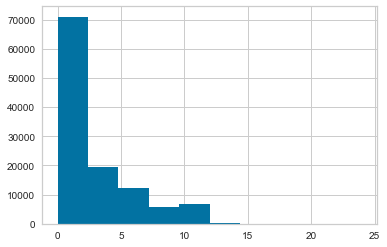

In [138]:
drop1['payment_installments'].hist(bins=10)

- Etude des clients par zone géographique

In [139]:
# Trouvons les états avec le plus de clients

customers_state = drop1.groupby(['customer_state']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
customers_state.rename(columns = {'customer_unique_id':'total'}, inplace=True)
customers_state['percentage'] = 100*(customers_state['total']/customers_state['total'].sum())
customers_state

,customer_state,total,percentage
25,SP,48797,42.208652
18,RJ,14987,12.963524
10,MG,13429,11.615878
22,RS,6413,5.547146
17,PR,5879,5.085244
23,SC,4218,3.648505
4,BA,3942,3.409769
6,DF,2449,2.118347
8,GO,2359,2.040499
7,ES,2300,1.989464


Sao Paulo est de loin l'état avec le plus de clients

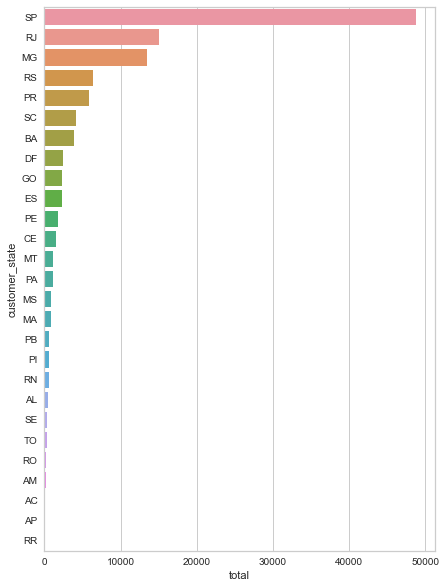

In [140]:
plt.figure(figsize=(7,10))
sns.barplot(data=customers_state,x='total',y='customer_state')
plt.show()

- Etude des clients par catégories de produits acheté

In [141]:
customers_cat = drop1.groupby(['product_category_name_english']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
customers_cat.rename(columns = {'customer_unique_id':'total'}, inplace=True)
customers_cat['percentage'] = 100*(customers_cat['total']/customers_cat['total'].sum())
customers_cat

,product_category_name_english,total,percentage
7,bed_bath_table,11847,10.247472
43,health_beauty,9944,8.601406
65,sports_leisure,8942,7.734692
39,furniture_decor,8743,7.562560
15,computers_accessories,8105,7.010700
...,...,...,...
3,arts_and_craftmanship,24,0.020760
52,la_cuisine,15,0.012975
11,cds_dvds_musicals,14,0.012110
29,fashion_childrens_clothes,8,0.006920


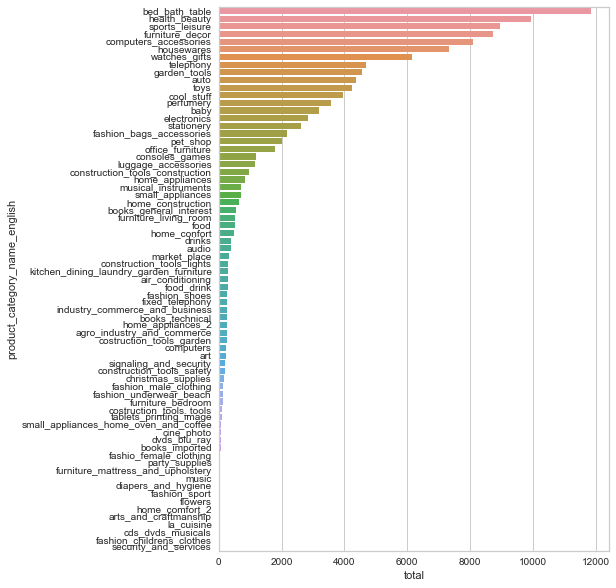

In [142]:
plt.figure(figsize=(7,10))
sns.barplot(data=customers_cat,x='total',y='product_category_name_english')
plt.show()

- Etude achats par date

In [143]:
purchase_year = drop1.groupby(['year']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_year.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_year['percentage'] = 100*(purchase_year['total']/purchase_year['total'].sum())
purchase_year

,year,total,percentage
2,2018,62721,54.252697
1,2017,52507,45.417744
0,2016,381,0.329559


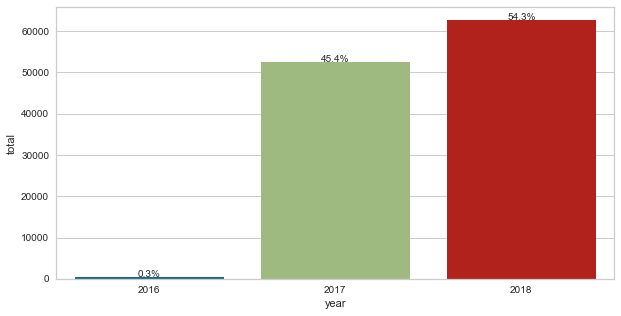

In [144]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_year,x='year',y='total')
total = purchase_year['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [145]:
# the number of order per month
purchase_monthly = drop1[['order_approved_at']].groupby(drop1['order_approved_at'].dt.to_period('M')).agg({'order_approved_at':'count'})
purchase_monthly = purchase_monthly.rename(columns = {'order_approved_at': 'total'})
purchase_monthly = purchase_monthly.reset_index()

purchase_monthly['month_year'] = purchase_monthly['order_approved_at'].dt.strftime('%b-%Y')
purchase_monthly.head()

,order_approved_at,total,month_year
0,2016-10,380,Oct-2016
1,2016-12,1,Dec-2016
2,2017-01,952,Jan-2017
3,2017-02,1988,Feb-2017
4,2017-03,3123,Mar-2017


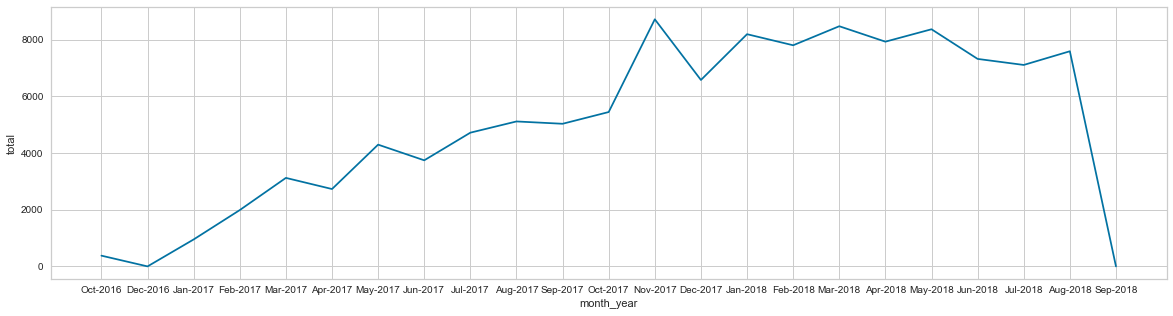

In [146]:
plt.figure(figsize=(20,5))
sns.lineplot(data=purchase_monthly,x='month_year',y='total')
plt.show()

Le plus grand nombre de commandes a été passé en Novembre 2017

In [147]:
order_monthly = drop1[['order_approved_at']].groupby(drop1['order_approved_at'].dt.month.sort_index()).count()
order_monthly

,order_approved_at
order_approved_at,
1.0,9144
2.0,9789
3.0,11596
4.0,10658
5.0,12662
6.0,11063
7.0,11825
8.0,12704
9.0,5033


In [148]:
month_index = order_monthly.rename(columns = {'order_approved_at': 'total_orders'})
monthly_trend = month_index.reset_index()

# rechange in to day in a week
moy = ['January','February','March','April','May','June','July','August','September','October','November','December']
for i in range(12):
  monthly_trend['order_approved_at'] = monthly_trend['order_approved_at'].replace(i,moy[i])
monthly_trend

,order_approved_at,total_orders
0,February,9144
1,March,9789
2,April,11596
3,May,10658
4,June,12662
5,July,11063
6,August,11825
7,September,12704
8,October,5033
9,November,5826


In [149]:
purchase_month = drop1.groupby(['month_name']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_month.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_month['percentage'] = 100*(purchase_month['total'] / purchase_month['total'].sum())
purchase_month

,month_name,total,percentage
1,August,12479,10.794142
8,May,12427,10.749163
5,July,12015,10.392789
7,March,11489,9.937808
6,June,11059,9.565864
0,April,10883,9.413627
3,February,9816,8.490688
4,January,9302,8.046086
9,November,8881,7.681928
2,December,6372,5.511682


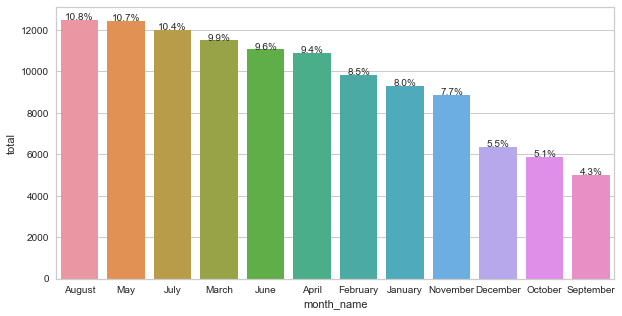

In [150]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_month,x='month_name',y='total')
total = purchase_month['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [151]:
purchase_day = drop1.groupby(['day_name']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_day.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_day

,day_name,total
1,Monday,18769
5,Tuesday,18768
6,Wednesday,18033
4,Thursday,17301
0,Friday,16532
3,Sunday,13722
2,Saturday,12484


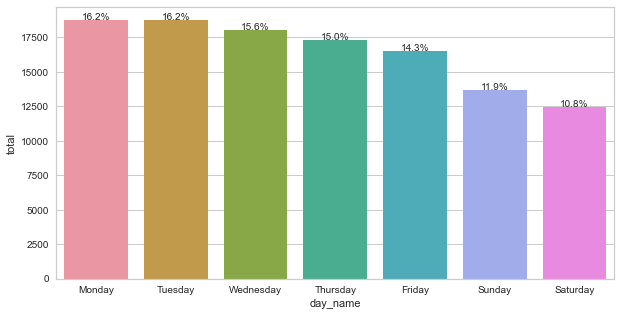

In [152]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_day,x='day_name',y='total')
total = purchase_day['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [153]:
payment_type = drop1.groupby(['payment_type']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
payment_type.rename(columns = {'customer_unique_id':'total'}, inplace=True)
payment_type['percentage'] = 100*(payment_type['total'] / payment_type['total'].sum())
payment_type

,payment_type,total,percentage
1,credit_card,85278,73.764153
0,boleto,22510,19.470802
3,voucher,6162,5.330035
2,debit_card,1659,1.435009


Le moyen de paiement le plus populaire est la carte de crédit ensuite boleto

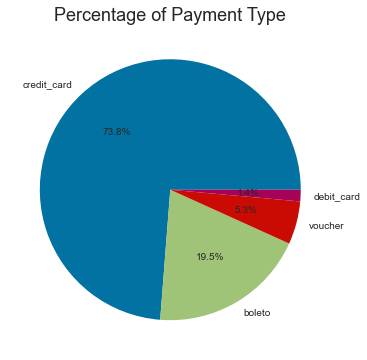

In [154]:
label = payment_type['payment_type']
plt.figure(figsize=(6,6))
plt.title('Percentage of Payment Type', fontsize = 18)
plt.pie(payment_type['total'], labels = label,autopct = '%0.1f%%')
plt.show()

<a name='C2'> - Classement par clients et commandes </a>

Calcul du nombre de clients ayant passé plus d'une commande

In [173]:
drop1.loc[drop1['customer_unique_id'] == 'ff4159b92c40ebe40454e3e6a7c35ed6'].reset_index()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,...,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,year,month,day,day_name,month_name
0,115571,f5136e38d1a14a4dbd87dff67da82701,1,1bdf5e6731585cf01aa8169c7028d6ad,ee27a8f15b1dded4d213a468ba4eb391,2017-06-15 02:45:17,6499.0,227.66,artes,art,...,1,6726.66,74210,goiania,GO,2017,5,2,Wednesday,May


Paiement moeyn par clients

In [174]:
mean_payment = drop1[['customer_unique_id','payment_value']].groupby(by=['customer_unique_id'],dropna=False).mean().reset_index()
count_payment = drop1[['customer_unique_id','payment_value']].groupby(by=['customer_unique_id'],dropna=False).count().reset_index()
result = pd.merge(mean_payment, count_payment, how="inner", on='customer_unique_id',suffixes=('_avg', '_count'))
result.sort_values('payment_value_avg',ascending=False).reset_index(drop=True)

,customer_unique_id,payment_value_avg,payment_value_count
0,0a0a92112bd4c708ca5fde585afaa872,13664.080000,8
1,763c8b1c9c68a0229c42c9fc6f662b93,7274.880000,4
2,dc4802a71eae9be1dd28f5d788ceb526,6929.310000,1
3,ff4159b92c40ebe40454e3e6a7c35ed6,6726.660000,1
4,4007669dec559734d6f53e029e360987,6081.540000,6
...,...,...,...
93391,c63a8c4fb13043a3fbe33bd17c69d17d,4.242500,8
93392,6bd5b501f37638859ccc1dc94cce730d,3.776667,9
93393,2bca5fe01d46ab5cc2bc5aaade88d850,3.166667,6
93394,569aa12b73b5f7edeaa6f2a01603e381,2.410769,26


In [175]:
customers_grp = drop1.groupby(['customer_unique_id','order_approved_at']).sum()
customers_grp

,,order_item_id,price,freight_value,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,year,month,day
customer_unique_id,order_approved_at,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,1,129.90,12.00,7787,5,1,8,141.90,13405,2018,5,3
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,1,18.90,8.29,6053,4,1,1,27.19,2215,2018,5,0
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,17.22,88115,3,1,8,86.22,13232,2017,3,4
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,1,25.99,17.63,66812,4,1,4,43.62,3569,2017,10,3
0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,1,180.00,16.89,18040,5,1,6,196.89,12327,2017,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16,3,1570.00,497.42,110500,10,2,20,4134.84,7816,4034,12,6
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20,1,64.89,19.69,44054,4,1,1,84.58,18500,2017,12,6
ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44,1,89.90,22.56,78552,5,1,1,112.46,30550,2017,2,1


In [159]:
sorted_customers_grp = customers_grp['payment_value'].value_counts().sort_values(ascending=False)
sorted_customers_grp

77.57      253
35.00      166
73.34      160
116.94     127
56.78      120
          ... 
630.40       1
384.30       1
144.28       1
272.92       1
4134.84      1
Name: payment_value, Length: 29860, dtype: int64

In [176]:
clients_num_orders = drop1.groupby('customer_unique_id').count()['order_approved_at'].sort_values(ascending=False)
clients_num_orders

customer_unique_id
9a736b248f67d166d2fbb006bcb877c3    75
6fbc7cdadbb522125f4b27ae9dee4060    38
f9ae226291893fda10af7965268fb7f6    35
8af7ac63b2efbcbd88e5b11505e8098a    29
569aa12b73b5f7edeaa6f2a01603e381    26
                                    ..
bc1896dc77f49e6dec880445a9b443a3     0
5a4fa4919cbf2b049e72be460a380e5b     0
f79be7c08dd24b72d34634f1b89333a4     0
d49f3dae6bad25d05160fc17aca5942d     0
c8822fce1d0bfa7ddf0da24fff947172     0
Name: order_approved_at, Length: 93396, dtype: int64

In [177]:
_clients_num_orders = drop1.groupby(['customer_unique_id','order_approved_at','payment_value','review_score'])['order_approved_at'].count().sort_values(ascending=False)
_clients_num_orders

customer_unique_id                order_approved_at    payment_value  review_score
9a736b248f67d166d2fbb006bcb877c3  2017-08-08 20:43:31  16.70          5               24
d97b3cfb22b0d6b25ac9ed4e9c2d481b  2017-10-18 13:06:21  853.95         1               22
4546caea018ad8c692964e3382debd19  2017-07-17 18:25:23  196.11         1               21
9a736b248f67d166d2fbb006bcb877c3  2017-08-08 20:43:31  2.61           5               21
c402f431464c72e27330a67f7b94d4fb  2018-02-24 03:20:27  2202.40        1               20
                                                                                      ..
59a2137051ddcd0ba1bc643a585a29e5  2017-09-07 02:44:07  190.06         3                1
59a17dcfcbfb81e6426ba122a8bbf5cb  2018-06-24 08:16:35  40.24          4                1
59a116551d6f781a536d874be20ea223  2018-01-30 18:10:34  61.05          1                1
599fc5c00b25842c502cd08f08791a1b  2018-04-04 23:50:17  58.69          5                1
ffffd2657e2aad2907e67c3e9da

In [162]:
review_score = drop1.groupby(['review_score']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
review_score.rename(columns = {'customer_unique_id':'total'}, inplace=True)
review_score['percentage'] = 100*(review_score['total'] / review_score['total'].sum())
review_score

,review_score,total,percentage
4,5,65374,56.547501
3,4,21951,18.987276
0,1,14546,12.582065
2,3,9718,8.405920
1,2,4020,3.477238


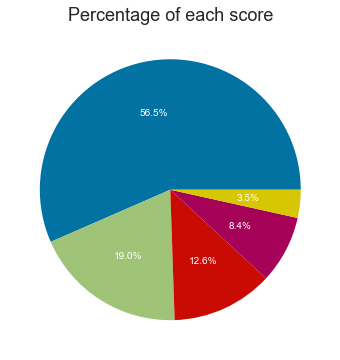

In [172]:
label = review_score['review_score']
plt.figure(figsize=(6,6))
plt.title('Percentage of each score', fontsize = 18)
plt.pie(review_score['total'], labels = label,autopct = '%0.1f%%', textprops={'color':"w"})
plt.show()

75% des clients ont donnée une note de 5 et 4

In [76]:
sum(clients_num_orders.values > 1)


14017

In [178]:
df_ = drop1[['customer_unique_id','order_approved_at','payment_value']].copy()
df_.head()

,customer_unique_id,order_approved_at,payment_value
0,871766c5855e863f6eccc05f988b23cb,2017-09-13 09:45:35,72.19
1,0fb8e3eab2d3e79d92bb3fffbb97f188,2017-06-29 02:44:11,73.86
2,3419052c8c6b45daf79c1e426f9e9bcb,2018-05-18 12:31:43,83.23
3,e7c828d22c0682c1565252deefbe334d,2017-08-01 18:55:08,75.07
4,0bb98ba72dcc08e95f9d8cc434e9a2cc,2017-08-10 22:05:11,72.19


In [179]:
df_clients = df_.groupby('customer_unique_id')[['order_approved_at','payment_value']].mean()
df_clients

,payment_value
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
0000f46a3911fa3c0805444483337064,86.22
0000f6ccb0745a6a4b88665a16c9f078,43.62
0004aac84e0df4da2b147fca70cf8255,196.89
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
fffea47cd6d3cc0a88bd621562a9d061,84.58
ffff371b4d645b6ecea244b27531430a,112.46


Calcul de la date de la première commande et celle de la dernière commande

In [180]:
print(f'Min : {min(drop1.order_approved_at)}, Max : {max(drop1.order_approved_at)}')

Min : 2016-10-04 09:43:32, Max : 2018-09-03 17:40:06


Nous allons utiliser la date de la dernière commande + 1 comme date de reference , afin de calculer la récense des commandes

In [181]:
last_date = drop1['order_approved_at'].max() + pd.to_timedelta(1, 'd')
last_date

Timestamp('2018-09-04 17:40:06')

In [194]:
rfm = drop1.reset_index()\
          .groupby('customer_unique_id')\
          .agg(Recency = ('order_approved_at', lambda x: (last_date - x.max()).days ),
                 Frequency = ('order_id', 'size'),
                 Monetary = ('payment_value', 'sum'),
                 score = ('review_score','mean'))

In [195]:
rfm

,Recency,Frequency,Monetary,score
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117.0,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,27.19,4.0
0000f46a3911fa3c0805444483337064,542.0,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,326.0,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,293.0,1,196.89,5.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452.0,2,4134.84,5.0
fffea47cd6d3cc0a88bd621562a9d061,267.0,1,84.58,4.0
ffff371b4d645b6ecea244b27531430a,574.0,1,112.46,5.0


In [184]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,93384.0,242.788465,153.133135,1.00,119.0,223.00,352.00,700.00
Frequency,93396.0,1.237837,0.847540,1.00,1.0,1.00,1.00,75.00
Monetary,93396.0,213.387431,631.534143,9.59,64.0,113.03,203.39,109312.64


In [185]:
percn = rfm[rfm['Frequency'] > 1].value_counts()
percn

Recency  Frequency  Monetary
411.0    2          310.28      6
283.0    2          266.68      4
201.0    2          253.08      3
118.0    2          279.60      3
411.0    2          293.36      3
                               ..
155.0    2          185.66      1
                    195.16      1
                    233.40      1
                    300.47      1
700.0    7          86.88       1
Length: 13943, dtype: int64

<AxesSubplot:xlabel='Frequency'>

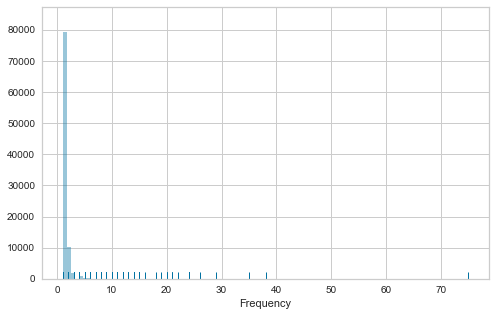

In [186]:
plt.figure(figsize=(8,5))
sns.distplot(rfm.Frequency,bins=100,kde=False,rug=True)

Text(0, 0.5, 'Frequency')

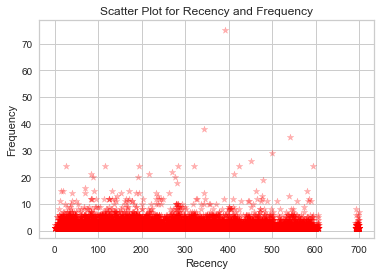

In [187]:
plt.scatter(rfm.groupby('customer_unique_id')['Recency'].sum(), rfm.groupby('customer_unique_id')['Frequency'].sum(),
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Recency')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

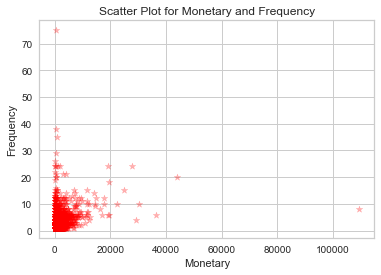

In [188]:
plt.scatter(rfm['Monetary'], rfm['Frequency'],
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Monetary and Frequency')
plt.xlabel('Monetary')
plt.ylabel('Frequency')

On peut voir que les clients qui achètent le plus souvent dépense moins d'argent.

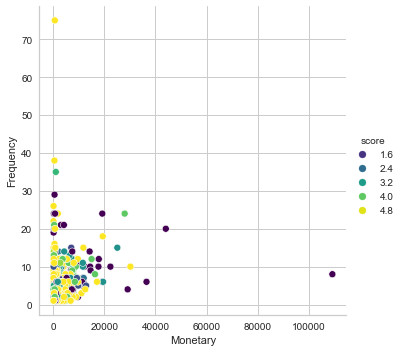

In [201]:
sns.relplot(
    data=rfm,
    x="Monetary", y="Frequency",
    hue="score",
    palette = 'viridis'
)